

**Цель исследования -разобраться в причинах убытков бизнеса.**

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

### Загрузим данные и подготовим их к анализу

In [1]:
# импортируем все нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# сохраним все датасеты в переменные
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# откроем первые 10 записей датасета с посещениями
visits.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


In [4]:
# посмотрим общую информацию
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
# и сразу посмотрим наличие явных дубликатов
visits.duplicated().sum()

0

Пропусков и явных дубликатов в данном датасете нет - отлично. Но вот с типом данных надо будет поработать: даты заменить на соответствующий тип данных. А также для удобной работы приведем названия столбцов к змеиному регистру.

In [6]:
# теперь ознакомимся с данными о покупках
display(orders.head(10))
display(orders.info())
orders.duplicated().sum()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

0

В данном датасете пропусков и явных дупликатов тоже нет - это не может не радовать. Однако снова нужно будет изменить тип данных столбца с датой и привести названия к змеиному регистру.

In [7]:
# ознакомимся с третьим датасетом о затратах на рекламу
display(costs.head(10))
display(costs.info())
costs.duplicated().sum()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

0

Пропусков и явных дубликатов нет и здесь, отлично! Только снова нужно будет разобраться с названиями столбцов. Посмотрим еще на наличие неявных дубликатов в столбцах, где возможны ошибки и опечатки:

In [8]:
# выведем уникальные значения
display(costs['Channel'].unique())
display(visits['Region'].unique())
display(visits['Device'].unique())
visits['Channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Нет, все названия записаны корректно, можно переходить к предобработке.

# Предобработка данных

In [9]:
# переведем названия столбцов к строчным буквам, а затем добавим нижнее подчеркивание в нужных столбцах
def rename_func(df):
    df.columns = df.columns.str.lower()
    return df
rename_func(visits)
rename_func(orders)
rename_func(costs)
visits = visits.rename(columns={'user id': 'user_id',
                                'session start': 'session_start',
                                'session end': 'session_end'})
orders = orders.rename(columns={'user id': 'user_id',
                               'event dt': 'event_dt'})

In [10]:
#проверим результат
display(visits.columns)
display(orders.columns)
costs.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Index(['dt', 'channel', 'costs'], dtype='object')

In [11]:
# переведем даты в нужный тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [12]:
# посмотрим результат
display(visits.dtypes)
display(orders.dtypes)
costs.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

dt          object
channel     object
costs      float64
dtype: object

Теперь названия столбцов в змеином регистре, типы данных соответствуют. Можно приступать к дальнейшим действиям.

# Вывод:
В результате предобработки все названия столбцов приведены к змеиному регистру, даты приведены к нужному типу данных. Пропусков, явных и неявных дубликатов в датасетах нет.


### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.



Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [13]:
def get_profiles (sessions, orders, ad_costs):
    # найдем параметры всех первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg({
                    'session_start': 'first',
                    'channel': 'first',
                    'device': 'first',
                    'region': 'first'
                })
                .rename(columns={'session_start': 'first_ts'})
                .reset_index()
               )
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Теперь зададим функцию дял расчета удержания - Retention Rate:

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
# собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Далее зададим функцию для расчёта конверсии:

In [15]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Зададим функцию для расчёта LTV и ROI:

In [16]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time # таблица динамики ROI
    ) 

И также зададим функции дял визуализации данных:

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    
    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Вывод: На этом шаге мы создали функции для дальнейших расчётов и построения графиков, теперь можем приступать к следующему шагу и использовать эти функции.

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.



In [20]:
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


Отлично, мы получили пользовательские профили, в которых указана дата первого посещения приложения, источник, устройство, с которого выполнен вход, регион, а также есть отдельный столбец, который делит пользователей на тех, кто уже оплачивал какие-либо услуги в приложении и тех, которые еще ничего не покупали.
Определим минимальную и максимальную даты привлечения пользователей без учета момента и горизонта анализа:

In [21]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
min_date, max_date

(datetime.date(2019, 5, 1), datetime.date(2019, 10, 27))

Действительно, как и было указано в условиях проекта: пользователи привлекались с 1 мая по 27 октября 2019 года. Но сегодня 1 ноября 2019 года, а в бизнес-плане указано, что пользователи должны окупаться через 2 недели после привлечения, определим максимально возможную дату привлечения, учитывая момент и горизонт анализа:

In [22]:
observation_date = datetime(2019,11,1).date()
horizon_days = 14
max_date = observation_date - timedelta(days=horizon_days-1)
max_date

datetime.date(2019, 10, 19)

С учётом момента и горизонта анализа максимально возможная дата привлечения пользователей 19 октября 2019 года. Это именно те пользователи, которые успели "дожить" до момента анализа.

Теперь построим таблицы по устройствам, регионам и рекламным платформам. Чтобы установить, какие пользователи приходят чаще и где выше доля платящих пользователей приложения.

In [23]:
# для этого сгруппируем данные по устройству и посчитаем количество уникальных пользователей и долю покупателей
profiles.groupby('device').agg({'user_id': 'nunique',
                               'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Таким образом, большая часть привлеченных пользователей выполняли вход с iPhone, а минимальное количество пользователей пользуются компьютерами Mac. При этом доля тех, кто совершал покупку, вышел среди пользователей Mac.

In [24]:
# теперь сгруппируем данные по региону и посчитаем количество уникальных пользователей и долю покупателей
profiles.groupby('region').agg({'user_id': 'nunique',
                               'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


Наибольшее количество пользователей из США, а вот меньшее количество людей приходит из Германии. При этом наибольшая доля платящих пользователей приходится на лиц из США, а вот меньше всего любят оплачивать услуги Французские пользователи приложения.

In [25]:
# теперь сгруппируем данные по платформе и посчитаем количество уникальных пользователей и долю покупателей
# так как здесь уже больше строк, сложно сравнить одновременно два показателя, поэтому выведем таблицу по количеству пользователей
# а ниже выведем платформу с максимальной и минимальной долей платящих пользователей
display(profiles.groupby('channel').agg({'user_id': 'nunique',
                               'payer': 'mean'}).sort_values(by='user_id', ascending=False))
display(profiles.groupby('channel').agg({'user_id': 'nunique',
                               'payer': 'mean'}).sort_values(by='payer', ascending=False).head(3))
profiles.groupby('channel').agg({'user_id': 'nunique',
                               'payer': 'mean'}).sort_values(by='payer', ascending=False).tail(2)


,user_id,payer
channel,,
organic,56439,0.020553
FaceBoom,29144,0.122049
TipTop,19561,0.096007
OppleCreativeMedia,8605,0.027077
LeapBob,8553,0.030633
WahooNetBanner,8553,0.052964
RocketSuperAds,4448,0.079137
MediaTornado,4364,0.035747
YRabbit,4312,0.038265


,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700


,user_id,payer
channel,,
OppleCreativeMedia,8605,0.027077
organic,56439,0.020553


Из данных видно, что наибольшее количество пользователей пришло органическим путем (бесплатные пользователи), среди рекламных платформ лидирует FaceBoom. При этом доля платящих пользоваталей, пришедших с FaceBoom максимально, а вот доля платящих бесплатных пользоваталей совсем небольшая. Среди рекламных платформ в аутсайдерах по количество покупателей OppleCreativeMedia.

# Вывод:
Таким образом, приложением пользуются владельцы iPhone, Android и даже ПК и Mac. При этом наибольшей популярностью приложение пользуется среди владельцев iPhone, хотя Mac незначительно перегоняет по количеству платящих пользователей (6.2 и 6.3% соответственно).
Приложение доступно для жителей четырех стран: США, Британия, Франция, Германия. При этом большей популярностью приложение пользуется у лиц из США, доля покупателей среди них также выше (~7%). А вот меньше всего любят оплачивать услуги Французы (3.7%). Среди рекламных платформ лидер по количеству привлеченных пользователей и по доле платящих - FaceBoom. А вот в аутсайдерах по покупателям услуг OppleCreativeMedia. При этом несмотря на довольно широкий круг различных рекламных платформ большая часть пользователей приходят органически - то есть самостоятельно (бесплатные пользователи), но и платят такие пользователи менее охотно.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постараемся отразить это на одном графике.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.



In [26]:
costs['costs'].sum()

105497.30000000002

Общий рекламный бюджет на привлечения с 1 мая по 27 октября 2019 года составил более 105 тысяч долларов.
Посмотрим, как распределился бюджет по платформам:

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


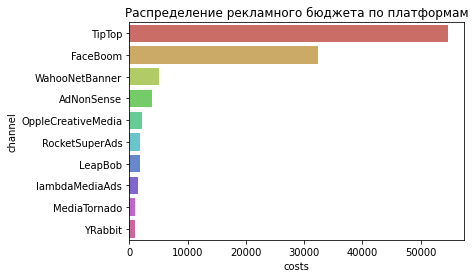

In [54]:
bar = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index()
display(bar)
sns.barplot(x=bar['costs'], y=bar['channel'], palette='hls')
plt.title('Распределение рекламного бюджета по платформам');

Более 50 тысяч (это примерно половина всего бюджета) уходит на рекламу на платформе TipTop, при этом по доле платящих пользователей данная платформа даже не в тройке лидеров. При этом лидер FaceBoom обходится компании на 20 тысяч дешевле.

                        Оценка динамики изменения рекламного бюджета
В предыдущем пункте мы оценивали общий бюджет без учета даты привлечения, сейчас посмотрим, как менялся бюджет в зависимости от недели, месяца.

In [28]:
# для начала создадим стобцы с месяцем и неделей
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,43,10
1796,2019-10-24,lambdaMediaAds,6.4,43,10
1797,2019-10-25,lambdaMediaAds,8.8,43,10
1798,2019-10-26,lambdaMediaAds,8.8,43,10


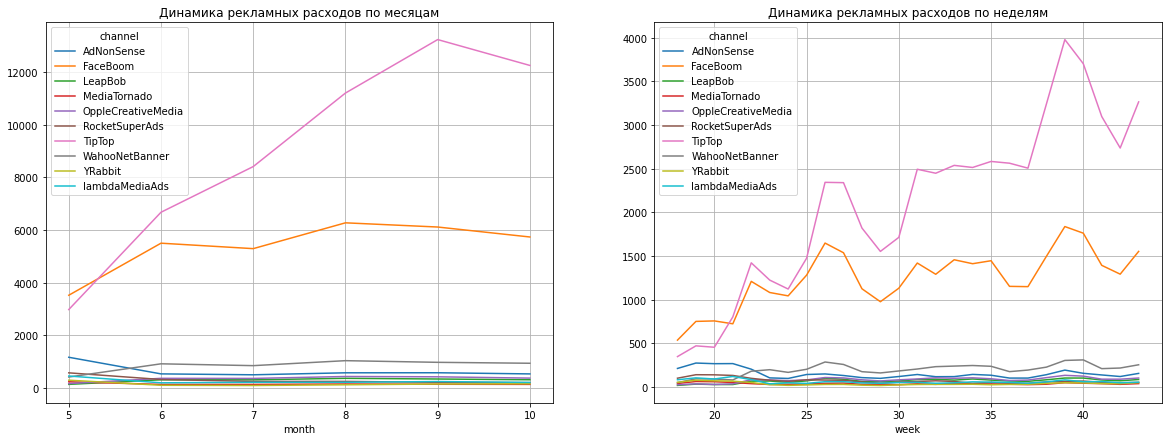

In [29]:
plt.figure(figsize=(20,7))
costs.pivot_table(
    index='month',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(grid=True, ax=plt.subplot(1,2,1));
plt.title('Динамика рекламных расходов по месяцам');
costs.pivot_table(
    index='week',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(grid=True, ax=plt.subplot(1,2,2));
plt.title('Динамика рекламных расходов по неделям');

Из графика сразу видны два лидера: TipTop и FaceBoom, при этом расходы на TipTop в два раза превосходили даже расходы на лидерскую платформу и постоянно росли, достигнув максимума в сентябре - ~14 тысяч долларов в месяц.
Однако на построенных графиках не очень видна динамика реклам с более низким бюджетом, попробуем исключить TipTop и FaceBoom и снова посмотреть на графики

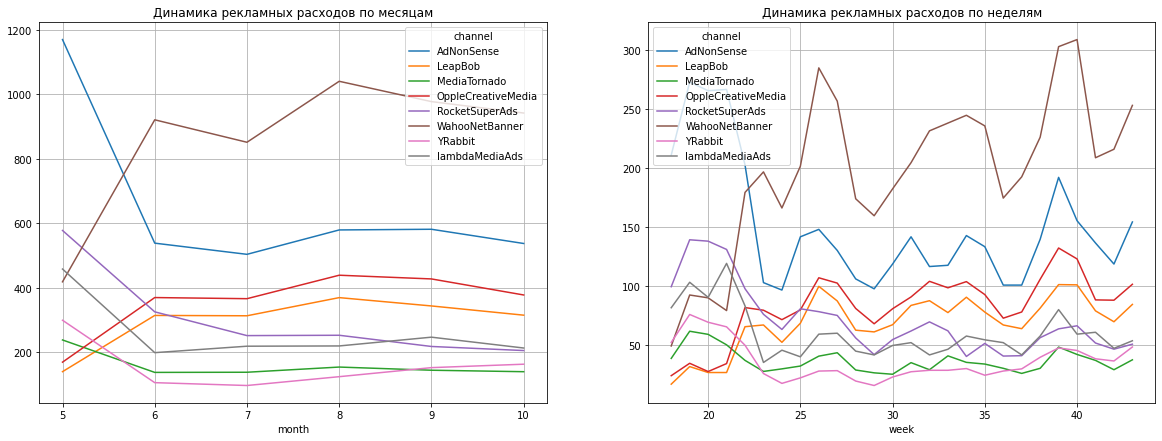

In [30]:
plt.figure(figsize=(20,7))
costs.query('channel != "TipTop" and channel != "FaceBoom"').pivot_table(
    index='month',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(grid=True, ax=plt.subplot(1,2,1));
plt.title('Динамика рекламных расходов по месяцам');
costs.query('channel != "TipTop" and channel != "FaceBoom"').pivot_table(
    index='week',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(grid=True, ax=plt.subplot(1,2,2));
plt.title('Динамика рекламных расходов по неделям');

Здесь стоимость более стабильна, нет такого резкого роста, как в расходах на TipTop. И в среднем расходы на другие платформы не превышали 1000 долларов в месяц.

           Расчёт средней стоимости привлечения одного человека для каждого источника
В полученных профилях есть столбец acquisition_cost - расход на привлечение одного пользователя, поэтому нам нужно сгруппировать данные по рекламным платформам и посчитать среднюю стоимость привлечения одного человека (CAC)

In [31]:
# сгруппируем данные, посчитаем среднюю стоимость привлечения одного человека, переименуем столбец и отсортируем по убыванию САС
cac = (profiles.groupby('channel')
       .agg({'acquisition_cost': 'mean'}).reset_index()
       .rename(columns={'acquisition_cost': 'cac'})
       .sort_values(by='cac', ascending=False)
      ) 
cac

,channel,cac
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


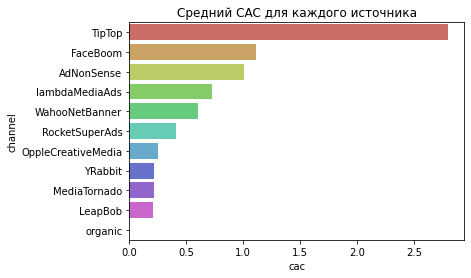

In [32]:
# для красоты и наглядности построим график
sns.barplot(x=cac['cac'], y=cac['channel'], palette='hls');
plt.title('Средний CAC для каждого источника');

Мы видим, что средняя стоимость привлечения одного человека с платформы TipTop составляет 2.8 долларов и превосходит FaceBoom более, чем в два раза. При этом данная платформа не является лидером по количеству привлеченных пользователей и доле платящих клиентов.
Стоимость одного пользователя на платформе FaceBoom составляет 1.1 доллар, для AdNonSense 1 доллар, для остальных платформ средний САС менее 1 доллара. Что, в приципе, логично: более дешевые платформы приводят меньше пользователей.
А вот TipTop совсем не соответствует такой картине.

Чтобы убедиться, насколько зашкаливает CAC у лидеров рекламных площадок, посмотрим средний CAC по всем площадкам:

In [33]:
print('Средний CAC по всем рекламным платформам:', round(profiles['acquisition_cost'].mean(),2))

Средний CAC по всем рекламным платформам: 0.7


Наглядно видно, что САС для платформы TipTop в 4 раза выше среднего.

# Вывод:
Таким образом, общая сумма расходов на рекламу с 1 мая по 27 октября 2019 года составила 105497 долларов.
Половина всего рекламного бюджета была вложена в платформу TipTop (более 54 тысяч долларов), на втором месте по сумме расходов платформа FaceBoom - бюджет 32 тысячи долларов. И лишь около 20 тысяч долларов ушло на все остальные 8 рекламных платформ.
При этом расходы на TipTop довольно резко росли, достигнув максимума в сентября 2019 года - 14 тысяч долларов в месяц. Более плавно рос бюджет расходов на рекламу платформы FaceBoom. На остальные 8 платформ бюджет вел себя более стабильно, при этом в среднем не поднимался выше 1000 долларов в месяц.
При подсчёте среднего CAC для каждой из платформ было обнаружено, что максимальная стоимость привлечения одного человека соответствует платформе TipTop и составляет 2.8 долларов, что превышает средний CAC в 4 раза. На втором месте вновь FaceBoom, однако разница более, чем в два раза, средний CAC для данной платформы 1.1 доллар. Для остальных платформ средняя стоимость привлеченного пользователя не превышала 1 доллара.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

      Изучение удержания, конверсии, LTV, ROI и CAC без разбивки по дополнительным признакам:

Исключим из датафрейма пользователей, которые пришли органическим путем - бесплатно. Так как нам нужно оценить именно проведенную рекламную кампанию и пользователей, пришедших оттуда.

In [34]:
profiles_comm = profiles.query('channel != "organic"')

С помощью уже заданных нами функция получим таблицы LTV, ROI и CAC и построим для них графики:

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_comm, orders, observation_date, horizon_days) 
# передадим функции нужные датафреймы, дату и горизонт анализа, которые мы задали выше

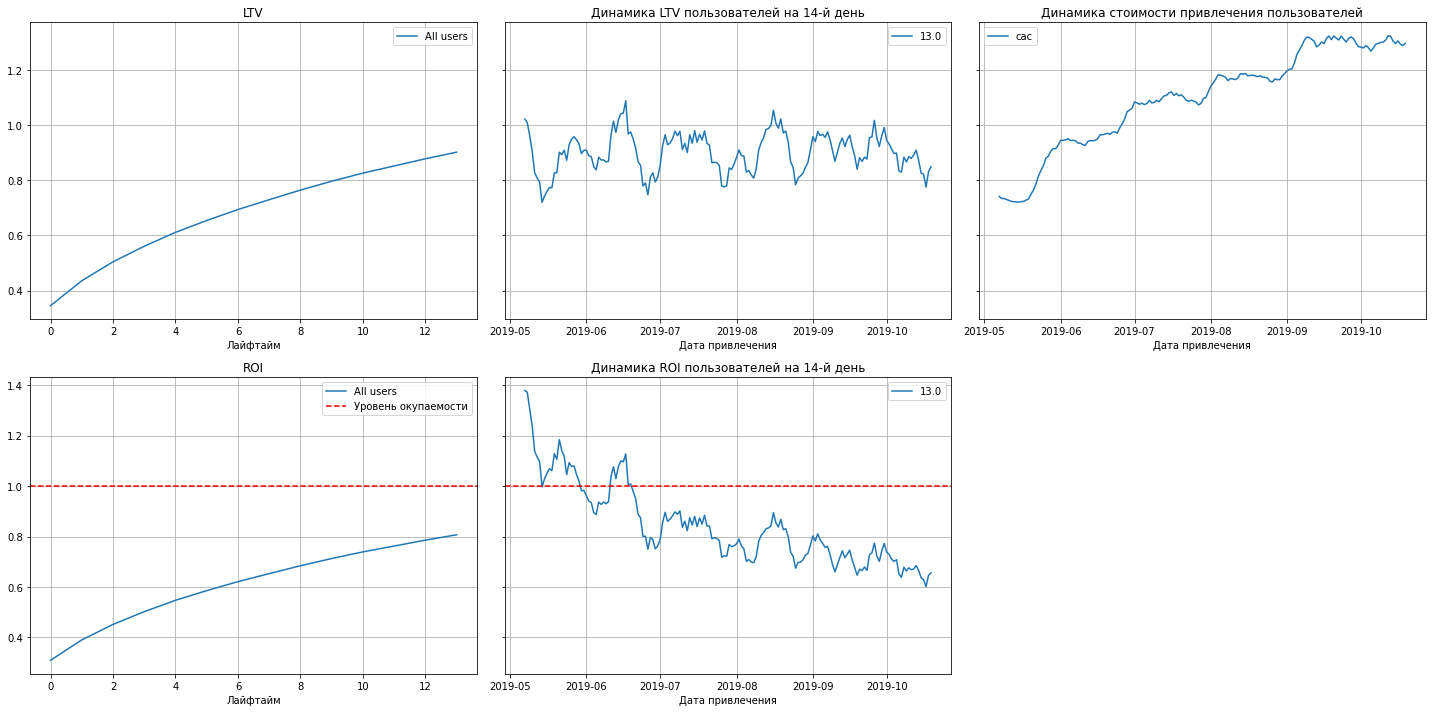

In [36]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) #построим графики

Изучив графики, можем сделать выводы:

LTV стабильно растет, как и должен, однако к концу второй недели реклама так и не окупается, достигает только 80%
при этом на графике динамики LTV наблюдаются небольшие подъемы и спады, скорее всего, связано с сезонностью, отрицательной динамики нет
зато мы видим, что стоимость привлечения пользователей постоянно растет, при этом окупаемость (динамика ROI) снижается. Так как ROI = LTV / CAC, при этом LTV стабильно растет, значит причина спада ROI - высокая стоимость рекламы, которая неуклонно растет
Посмотрим более детально и изучим остальные признаки - рекламная платформа, регион, устройство. Хотя данные из предыдущих пунктов могут натолкнуть на мысль, что виной убытков - дорогая и неэффективная реклама в TipTop, но для начала изучим все варианты.

Для начала построим графики конверсии и удержания:

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,81334,1.0,0.176876,0.086594,0.051823,0.033504,0.024701,0.018651,0.014188,0.011729,0.009541,0.007488,0.006393,0.006012,0.004709
True,7310,1.0,0.380985,0.293023,0.235568,0.210260,0.191245,0.166758,0.156908,0.145144,0.136389,0.135021,0.121888,0.118741,0.104925


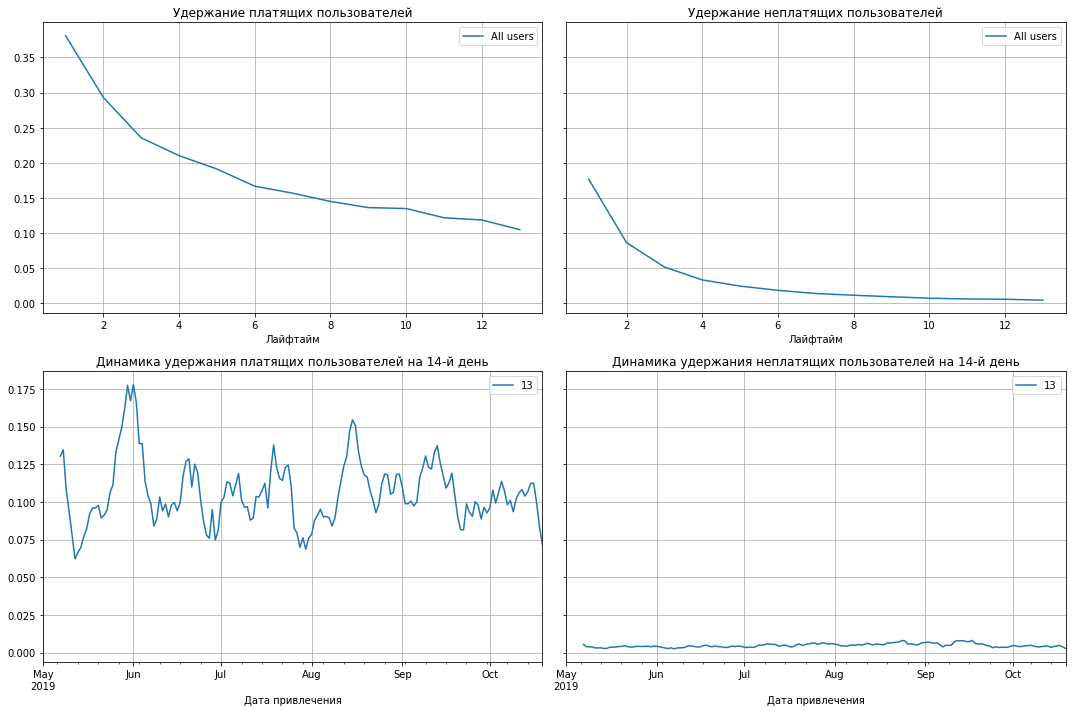

In [37]:
# передадим функции нужные датасеты, момент и горизонт анализа
retention_raw, retention_grouped, retention_history = get_retention(profiles_comm, visits, observation_date, horizon_days)
display(retention_grouped) # выведем на экран таблицу удержания
plot_retention(retention_grouped, retention_history, horizon_days) # построим графики для платящих и неплатящих польз

Изучив графики и таблицу, можно сделать выводы:

1) когорта неплатящих пользователей превосходит платящих в 16 раз, но при этом как и следовало ожидать, удержание платящих пользователей выше;
2) при этом около 12% платящих пользователей продолжают пользоваться приложением спустя 2 недели после привлечения;
3) динамика удержания имеет пики и спады, скорее, связанные с сезонностью;
4) удержание неплатящих пользователей к концу второй недели стремится к нулю (0.4%)

Теперь посмотрим на общую конверсию пользователей:

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.058752,0.066321,0.069999,0.072571,0.0745,0.075775,0.076745,0.077591,0.078291,0.078945,0.079362,0.079678,0.079904,0.080197


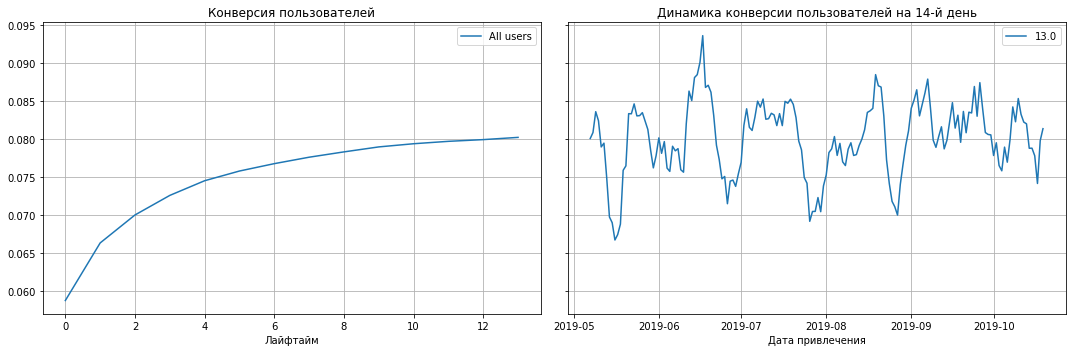

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_comm, orders, observation_date, horizon_days)
display(conversion_grouped)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

В среднем пользователи конвертируются хорошо, к концу второй недели конверсия составляет 8%. Динамика имеет сезонность, но в общем стабильна.

                Изучение удержания, LTV, ROI и CAC с разбивкой на устройства:

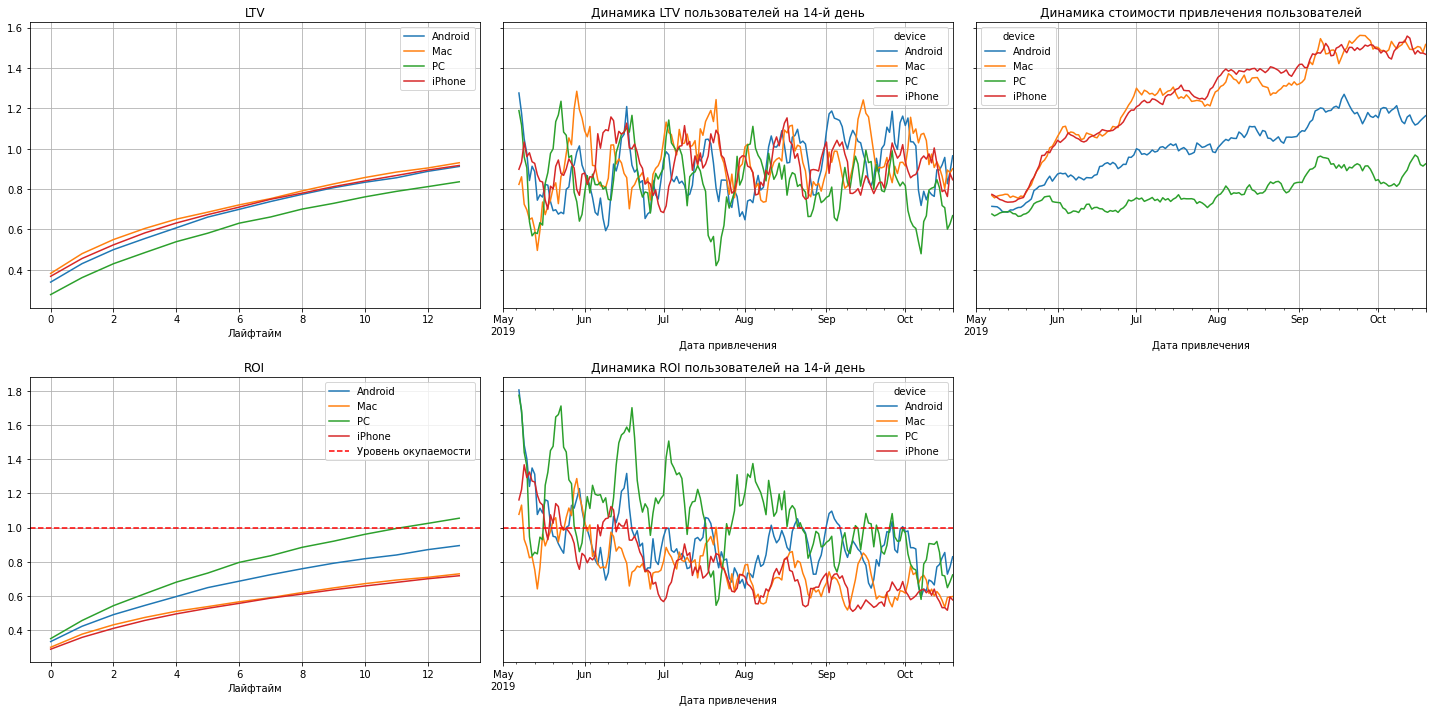

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_comm, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days,
                                                                      dimensions = ['device']) 
# передадим функции нужные датафреймы, дату и горизонт анализа, которые мы задали выше
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) #построим графики

Из графиков можем сделать выводы:

1)LTV пользователей PC ниже других, при этом у них самая высокая окупаемость, если посмотреть на график стоимости рекламы, можно увидеть, что реклама приложения на PC заметно дешевле других, и ее стоимость была более стабильна за эти несколько месяцев
2)при этом самая дорогая реклама для приложения на iPhone и Mac. И она не окупается. Так как LTV для этих двух устройств постоянно плавно растет (и даже выше, чем PC), можно сделать вывод, что отсутствие окупаемости связано с высокой стоимостью рекламы
3)окупается к концу второй недели только реклама для приложений на PC
4)динамика ROI отрицательная, окупаемость снижается с ростом стоимости рекламы, при этом динамика LTV вполне нормальная с сезонными изменениями

Так как меня насторожило низкое удержание неплатящих пользователей, посмотрим на графики удержания с разбивкой на устройства, вдруг есть еще и какая-то техническая проблема:

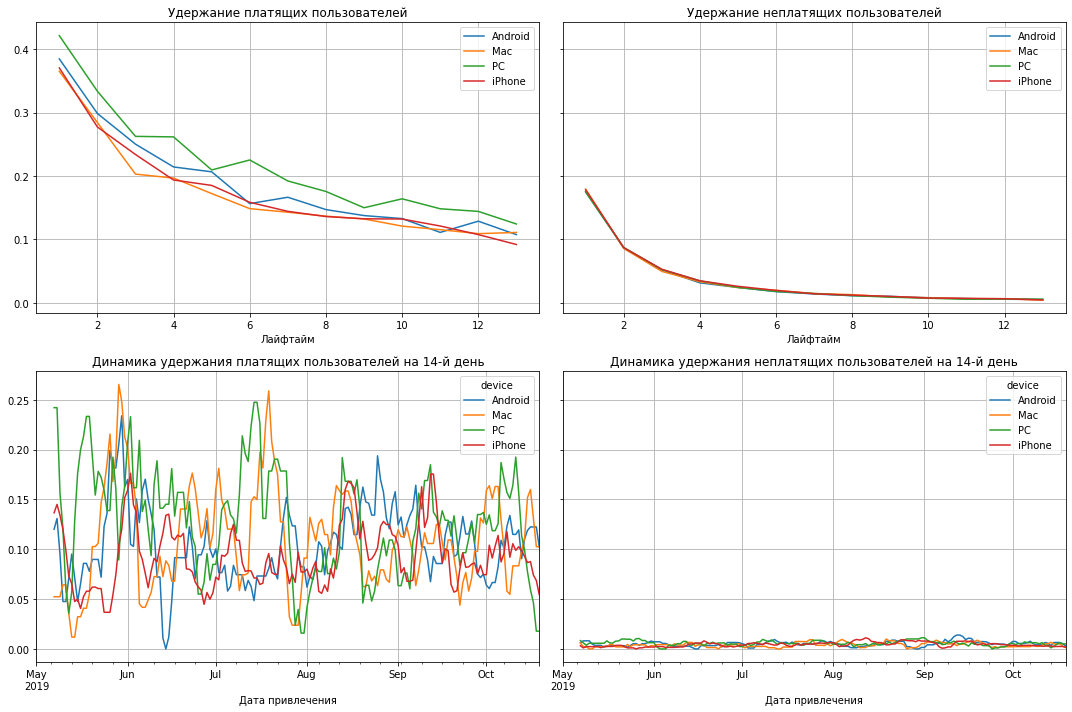

In [40]:
# передадим функции нужные датасеты, момент и горизонт анализа
retention_raw, retention_grouped, retention_history = get_retention(profiles_comm, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days,
                                                                    dimensions=['device'])
plot_retention(retention_grouped, retention_history, horizon_days) # построим графики для платящих и неплатящих пользовател

Нет, гипотеза о наличии технической проблемы не подтвердилась: графики удержания примерно одинаковы для пользователей со всеми устройствами. Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

Посмотрим на конверсию, в зависимости от устройства:

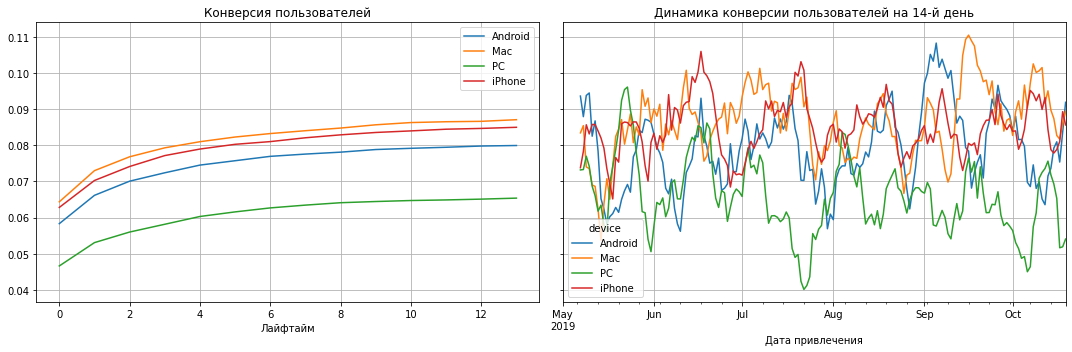

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_comm, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days,
                                                                        dimensions = ['device'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Стоит отметить, что конвертируются пользователи с iPhone и Mac хорошо, но несмотря на это не окупаются, что еще раз подтверждает нам гипотезу о слишком дорогой рекламе.

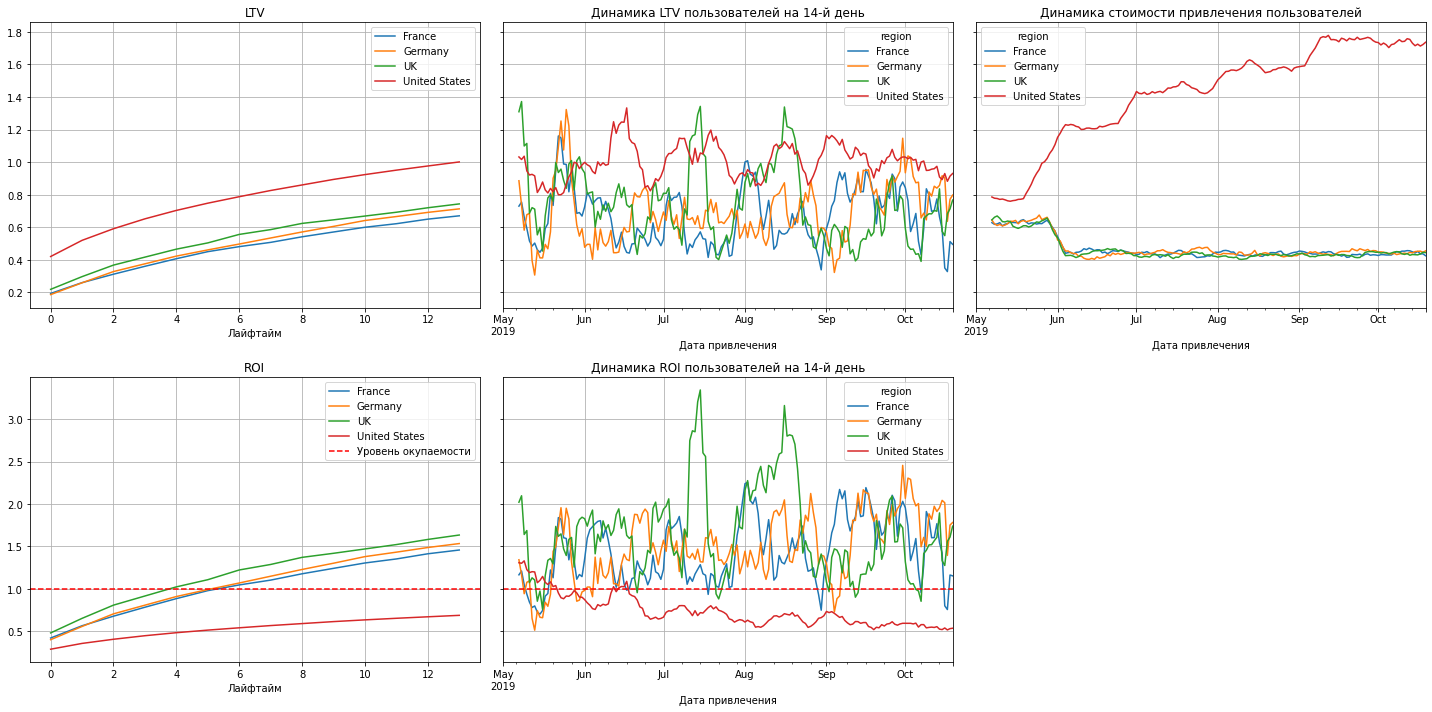

In [42]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_comm, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days,
                                                                      dimensions = ['region']) 
# передадим функции нужные датафреймы, дату и горизонт анализа, которые мы задали выше
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) #построим графики

Делаем выводы из графиков:

1) реклама для пользователей из США, не окупается, даже при самом высоком LTV
2) при этом стоимость рекламы в США резко растет, за счёт этого она не может окупиться
3) стоимость рекламы для остальных стран более стабильна и реклама окупается даже при LTV ниже США
4) в графике динамики ROI можем увидеть, как после резкого увеличения стоимости рекламы в США резко упала ее окупаемость
5) при этом LTV в динамике имеет сезонный характер

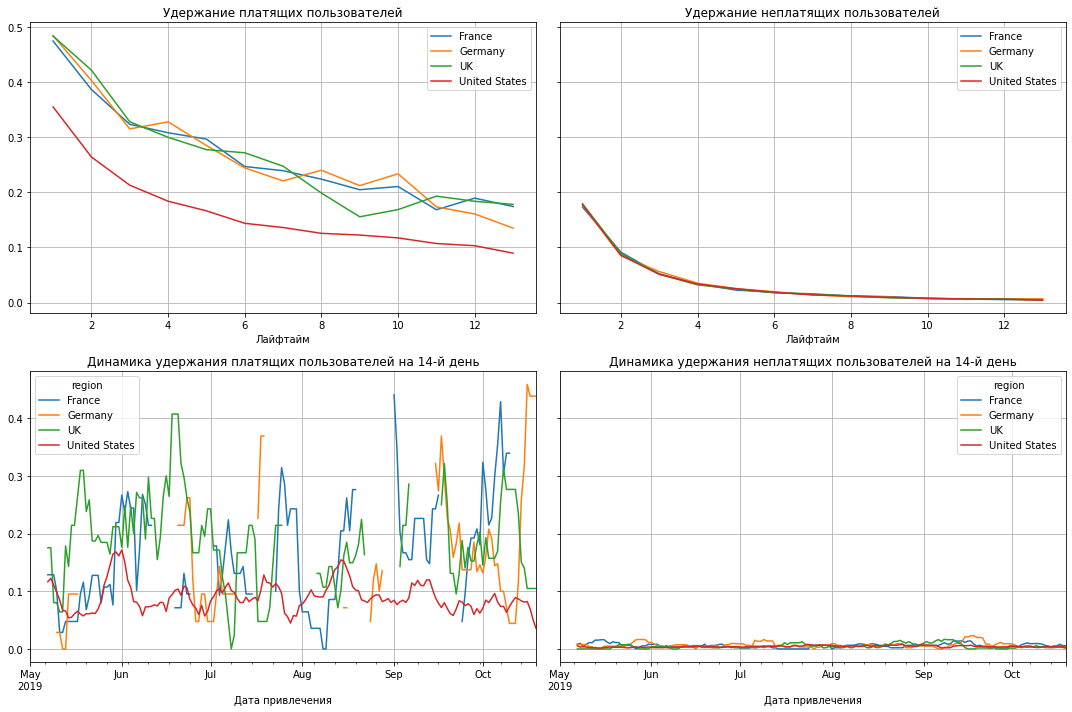

In [43]:
# передадим функции нужные датасеты, момент и горизонт анализа
retention_raw, retention_grouped, retention_history = get_retention(profiles_comm, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days,
                                                                    dimensions=['region'])
plot_retention(retention_grouped, retention_history, horizon_days) # построим графики для платящих и неплатящих пользов

Пользователи из США удерживаются примерно на 10% ниже, чем пользователи из других стран. При этом среди них максимальная доля платящих пользователей, может быть, дело в рекламной кампании? Предлагают какую-то скидку или прмокод на услугу, но после однократной покупки люди перестают пользоваться приложением? Стоит выяснить у маркетологов.
Но нелпатящие пользователи удерживаются одинаково низко из всех стран.

Что с конверсией?

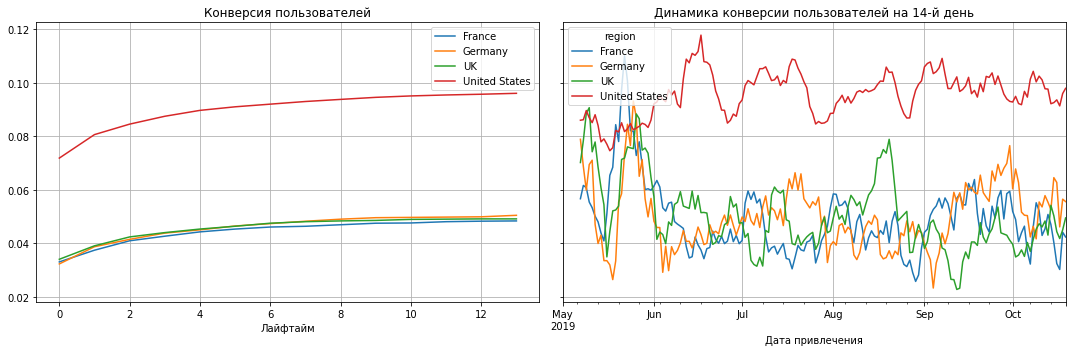

In [44]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_comm, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days,
                                                                        dimensions = ['region'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Как в случае и с устройствами. Мы видим, что пользователи из США очень хорошо конвертируются, однако не окупаются, еще раз убеждаемся, что причина в дорогой рекламе.

        Изучение удержания, LTV, ROI и CAC с разбивкой на рекламные платформы:

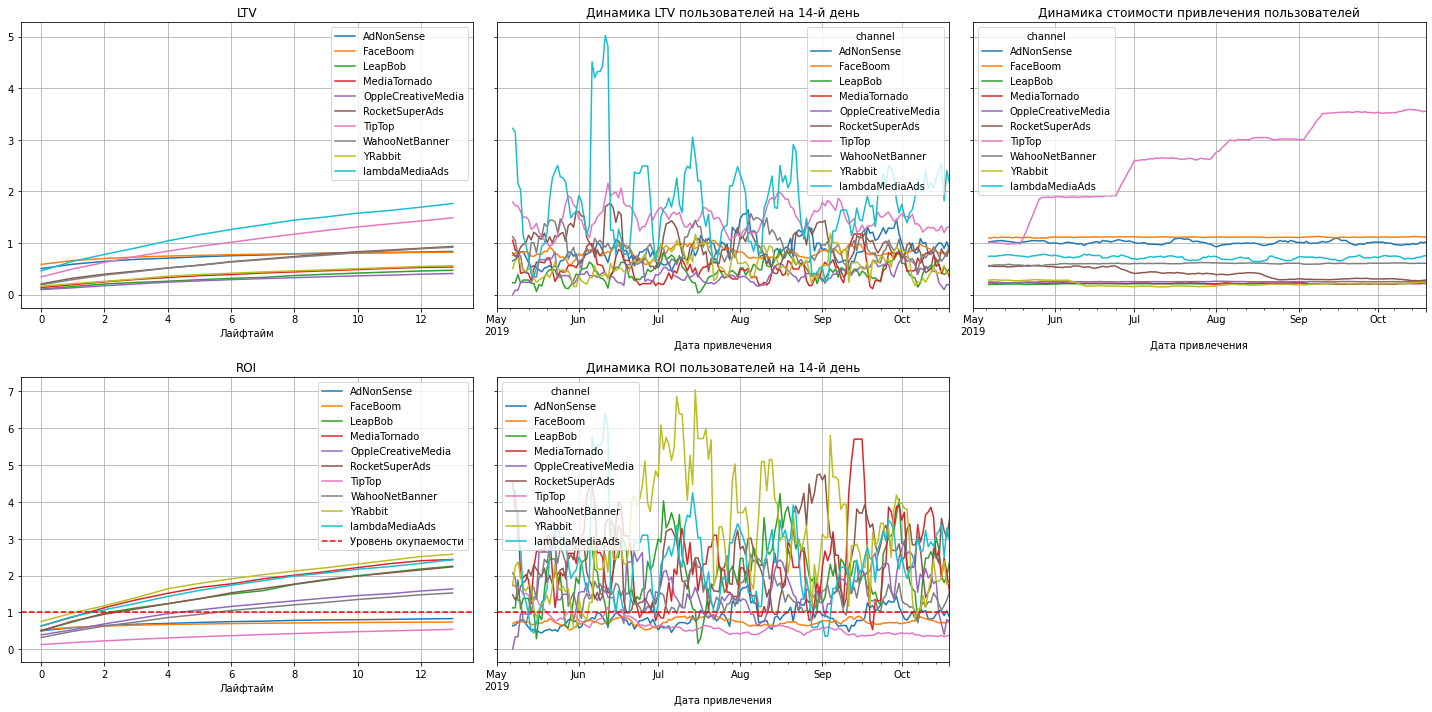

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_comm, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days,
                                                                      dimensions = ['channel']) 
# передадим функции нужные датафреймы, дату и горизонт анализа, которые мы задали выше
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) #построим графики

Даже по таким графикам можно увидеть некоторые закономерности, однако сложно их анализировать, поэтому я решил разбить рекламные платформы на две подгруппы в зависимости от страны - США и Европа:

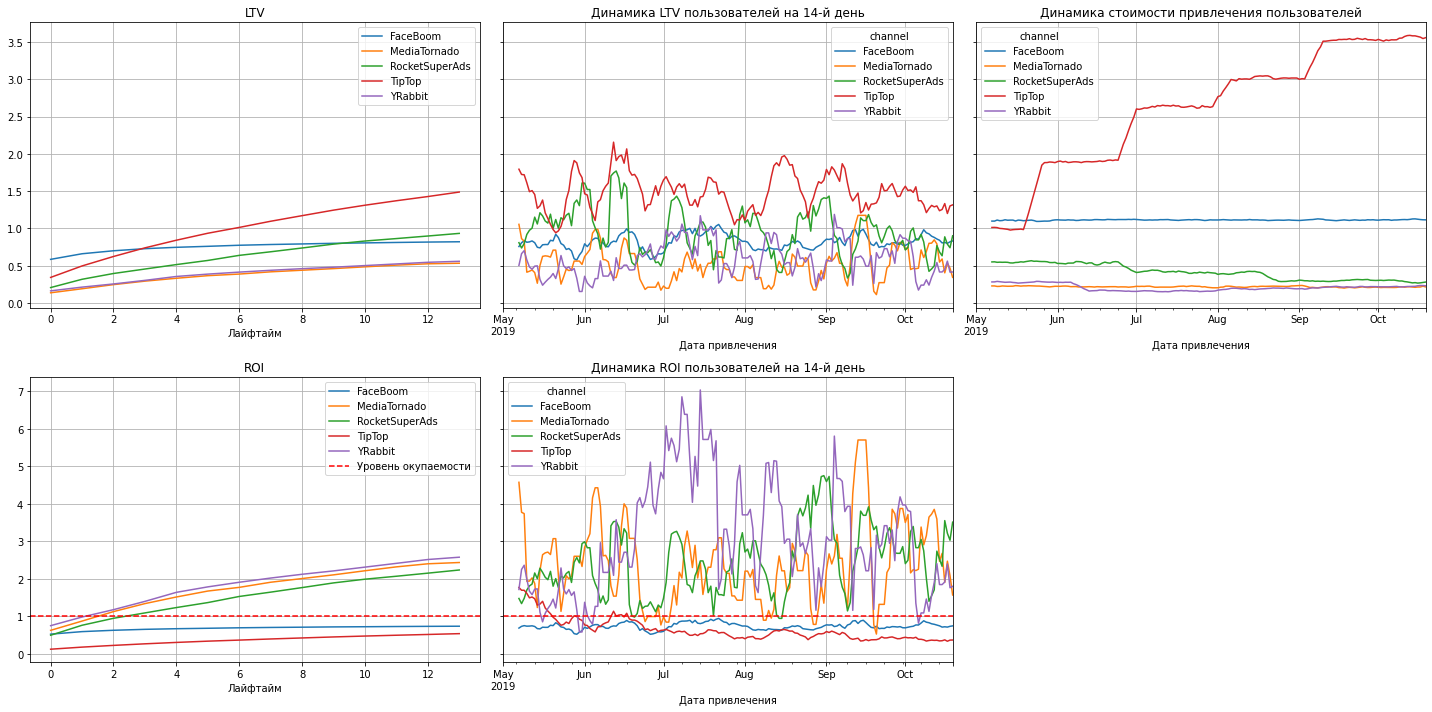

In [46]:
profiles1 = profiles_comm.query('region == "United States"')
profiles2 = profiles_comm.query('region != "United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles1, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days,
                                                                      dimensions = ['channel']) 
# передадим функции нужные датафреймы, дату и горизонт анализа, которые мы задали выше
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) #построим графики

Из графиков мы видим:

1) три платформы - YRabbit, RocketSuperAds, MediaTomado окупаются уже на третий день, однако имеют более низкий LTV, вероятно, окупаемость связана с низкой стоимостью
2) а вот реклама на других платформах не окупается за все две недели, при этом на платформе TipTop постоянно растет стоимость размещения, с чем и может быть связано отсутсвие окупаемости, ведь LTV у этой платформы высокий
3) несмотря на лидерство по количеству пользователей и доле платящих клиентов реклама на FaceBoom не окупается, даже при относительно не высокой стоимости и имеет не очень впечатляющий LTV.

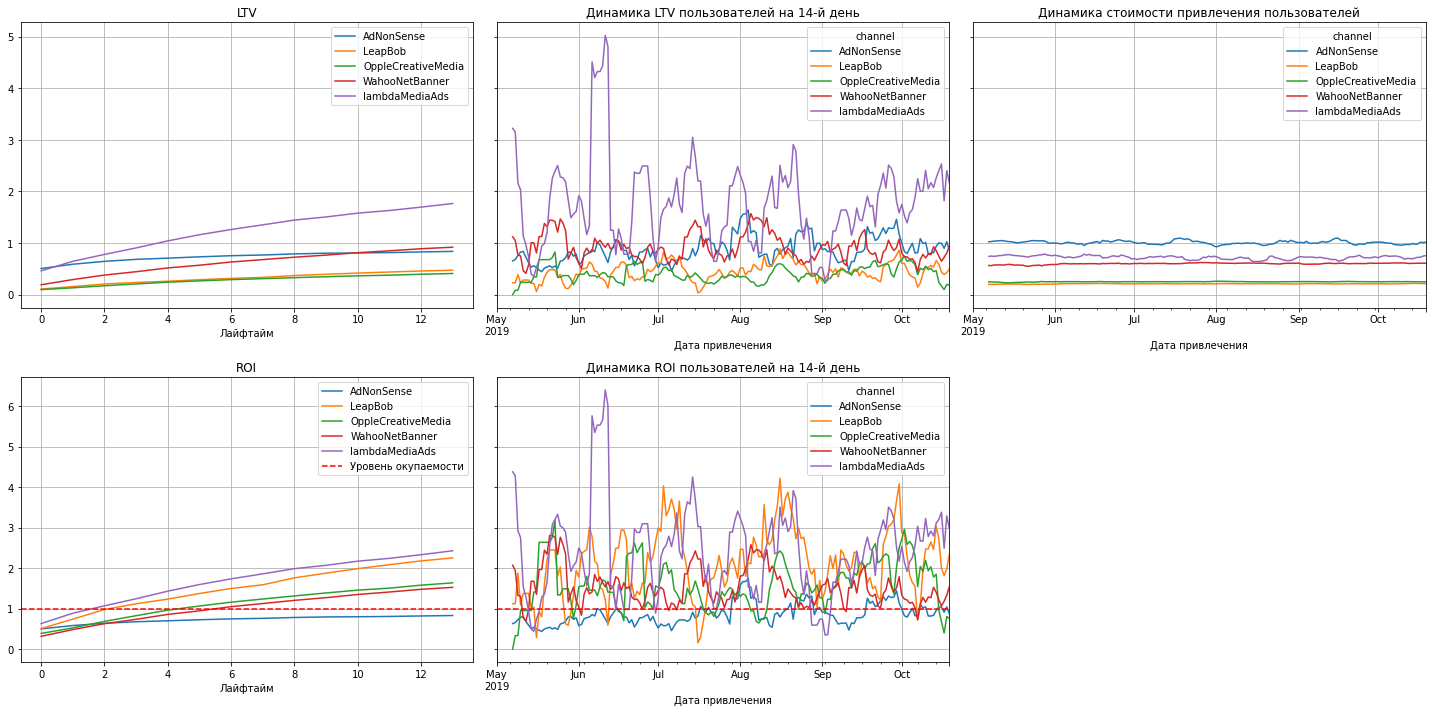

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles2, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days,
                                                                      dimensions = ['channel']) 
# передадим функции нужные датафреймы, дату и горизонт анализа, которые мы задали выше
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) #построим графики

У Европейской группы платформ наблюдается следующая картина:

1) есть площадка , которая окупается на третий день, при этом имеет высокий показатель LTV и низкую стоимость - lambdaMediaAds
2) а вот реклама на площадке AdNonSense не окупается за две недели даже при низкой стоимости размещения

Посмотрим на удержание пользователей с различных платформ:

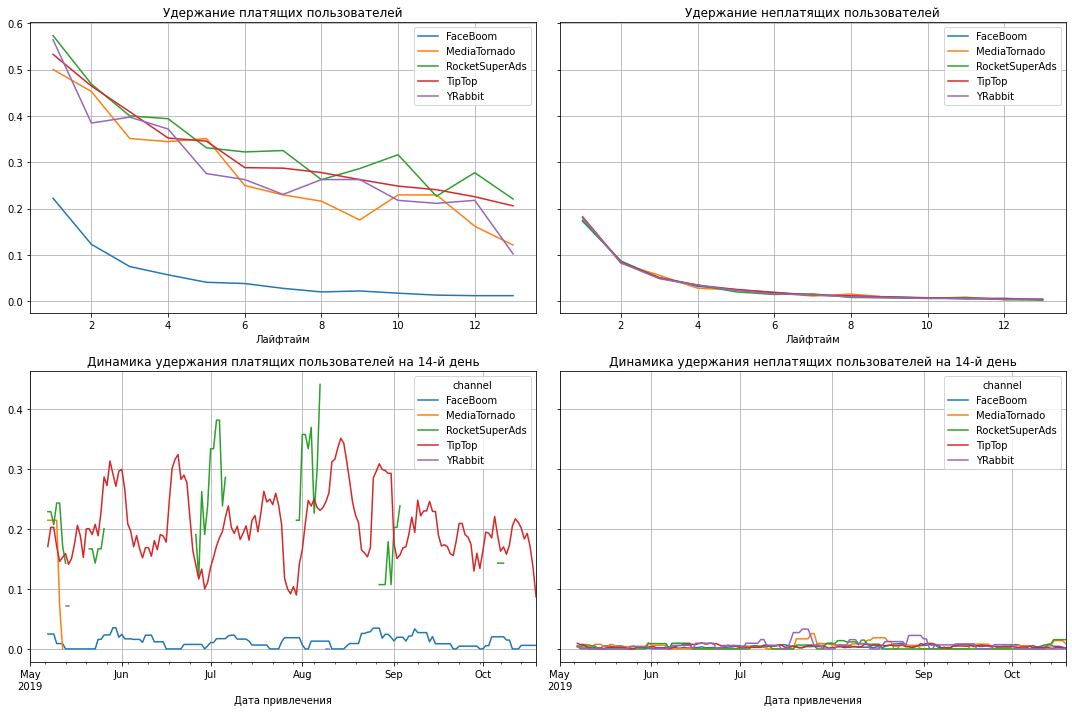

In [48]:
# передадим функции нужные датасеты, момент и горизонт анализа
retention_raw, retention_grouped, retention_history = get_retention(profiles1, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days,
                                                                    dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon_days) # построим графики для платящих и неплатящих пользовател

Хуже всего удерживаются пользователи, пришедшие с платформы FaceBoom.

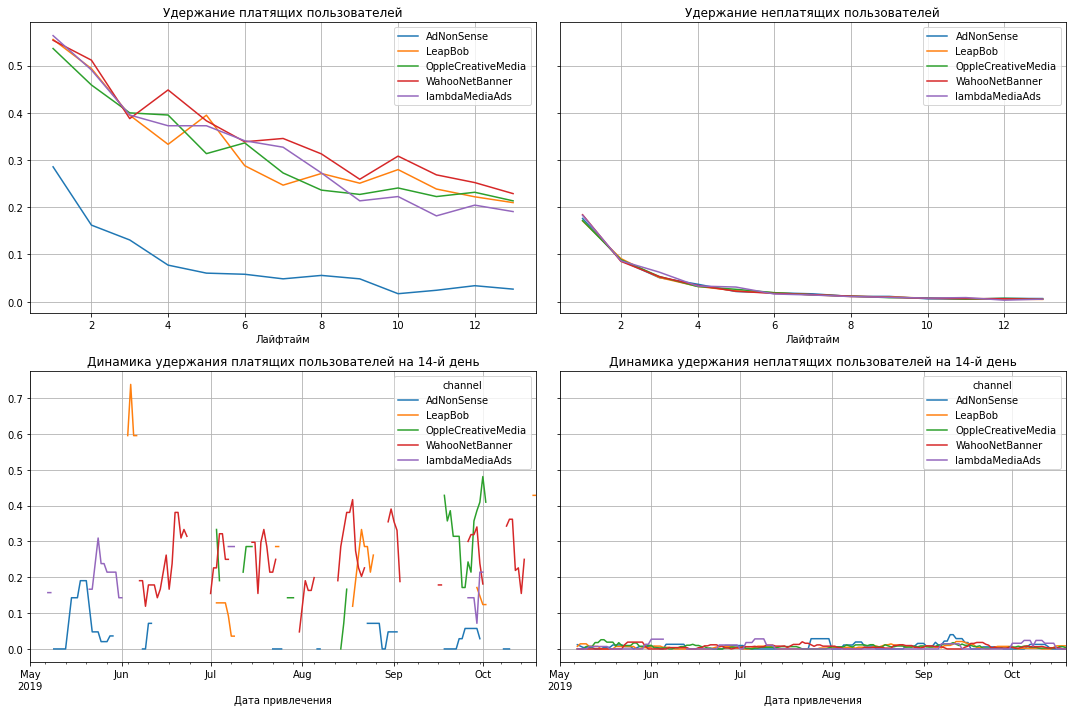

In [49]:
# передадим функции нужные датасеты, момент и горизонт анализа
retention_raw, retention_grouped, retention_history = get_retention(profiles2, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days,
                                                                    dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon_days) # построим графики для платящих и неплатящих пользовател

А здесь явно проблемы с удержанием пользователей от AdNonSense, что и может являться причиной неокупаемости при низкой стоимости и хорошей LTV.

Посмотрим на конверсию:

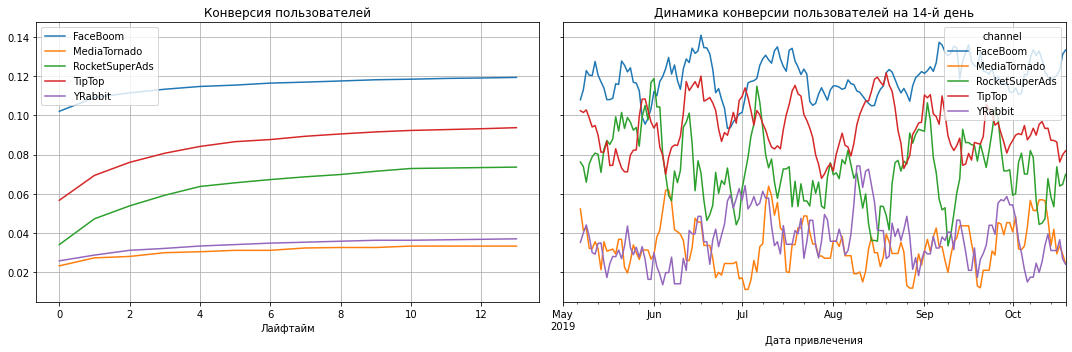

In [50]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles1, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days,
                                                                        dimensions = ['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи с FaceBoom довольно хорошо конвертируются, но при этом не окупаются и имеют низкое удержание, даже несмотря на более дешевое размещение. Может быть, пересмотреть рекламную кампанию на этой площадке, ведь с FaceBoom приходит очень большое количество людей. Может есть какое-то горящее предложение для пришедших оттуда, но после однократной покупки клиенты перестают пользователься приложением, как в случае с США? Такую же ситуацию мы наблюдали и с жителями США, а эта платформа как раз направлена на их привлечение. Может быть, стоит подумать об удержании этих пользователей.

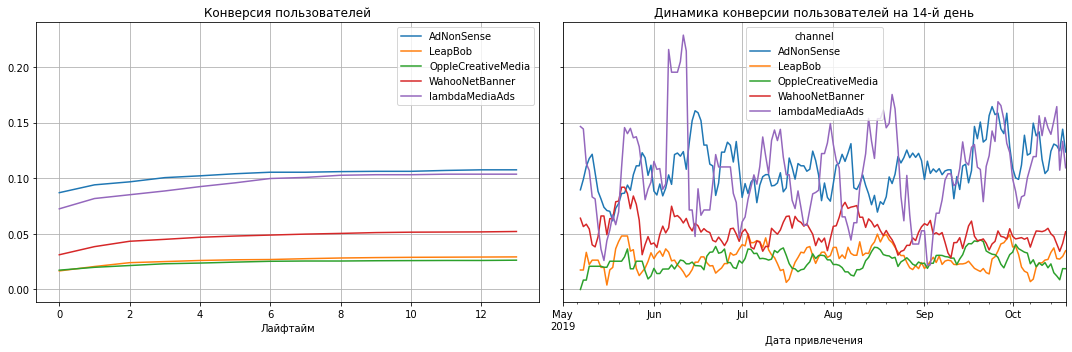

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles2, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days,
                                                                        dimensions = ['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Очень хорошую высокую конверсию показывает рекламная платформа AdNonSense, но при этом не окупается, даже имея невысокую стоимость размещения. Значит, всё-таки проблема в удержании. Стоит подумать над бонусами, челленджами и ежедневными заданиями для пользователей. Также обращает на себя внимание площадка lambdaMediaAds, она окупается, имеет небольшую стоимость размещения, хорошо удерживает пользователей, при этом здесь и конверсия довольно высокая.

# Вывод:
Таким образом, можно сделать вывод, что в целом реклама приложения не окупается. ROI к концу второй недели достигает лишь 80%. При этом общая стоимость рекламы растет, а окупаемость в динамике снижается пропорционально росту стоимости.
Негативное влияние на окупаемость оказывают устройства iPhone и Mac, стоимость размещения рекламы для этих устройств неуклонно растет и даже при нормальной конверсии реклама не окупается.
Также влияет страна, на которую направлена рекламная кампания: так, в США реклама не окупается к концу второй недели, стоимость размещения растет, при этом конверсия нормальная, но удержание ниже, чем у других стран.
Не окупается за две недели реклама, размещенная на платформах FaceBoom, TipTop и AdNonSense. При этом если на TipTop неокупаемость связана с высокой стоимостью размещения, то другие две платформы не могут коупить даже при относительно стабильной низкой стоимости. Поэтому были изучены удержание и конверсия для этих платформ, обнаружно, что пользователи, пришедшие из FaceBoom и AsNonSense перестают пользоваться приложением к концу второй недели: удержание близко к нулю.
Значит, проблемы с окупаемостью могут быть связаны с высокой и постоянно увеличивающейся стоимостью рекламы на некоторых площадках, особенно для некоторых стран и устройств. А также с низким удержанием пользователей с двух площадок. При этом у более дешевых платформ низкая конверсия пользователей.\ Есть ряд закономерностей и интересных наблюдений, который будут полезны отделу маркетинга, поэтому переходим к общим выводам.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

На этапе ознакомления с датафреймами дубликатов, пропусков в данных не обнаружено, что говорит о хорошем, коректном сборе данных. На этапе предобработки были заменены типы данных для дат, а также переименованы столбцы: в соответствие с правилами хорошего тона приведены к змеиному регистру.

Приложение доступно для iPhone, Mac, Android и PC. При этом большинство пользователей с большим отрывом - владельцы iPhone (54 тысячи человек). При этом меньше всего приложение пользуется популярностью среди владельцев Mac. Но доля платящих пользователей с Mac незначительно выше доли платящих пользователей с iPhone (6.3% и 6.2% соответственно). Приложение доступно для четырех стран: США, Британия, Франция, Германия. При этом основная масса пользователей - жители США (более 100 тысяч человек), а на три другие страны приходится 50 тысяч пользователей. Доля покупателей среди жителей США так же выше (7%), а вот менее охотно оплачивают услуги лица из Франции - всего 3.7%. Лидер по количеству пользователей среди рекламных платформ - FaceBoom (29 тысяч), также среди лиц, привлеченных с этой платформы, доля платящих пользователей выше, чем среди других (12%). В аутсайдерах по количеству платящих пользователей платформа OppleCreativeMedia. Несмотря на большое количество рекламных платформ, большая часть пользователей приходит самостоятельно, то есть бесплатно - это 56 тысяч пользователей. Но вот доля платящих среди пришедших органически минимальна и составила всего 2%.

В ходе исследования была подсчитана общая сумма расходов на рекламу с 1 мая по 27 октября 2019 года - она составила 105497 долларов. При этом практически половина всего рекламного бюджета была вложена в размещение на платформе TipTop (более 50 тысяч долларов), на втором месте по сумме расходов платформа FaceBoom (33 тысячи долларов), которая лидирует по количеству привлеченных пользователей и доле платящих среди них. И лишь около 20 тысяч долларов ушло на все остальные 8 платформ. При этом на графике динамики обнаружен резкий рост расходов на рекламу в TipTop, в сентябре 2019 года он достиг своего максимума - 14 тысяч долларов в месяц. Бюджет на рекламу в FaceBoom рос более плавно в течение этих месяцев. Расходы на остальные 8 платформ был более стабилен - в среднем не полнимался более 1000 доларов в месяц. Также была подсчитана средняя стоимость привлечения одного человека для каждой из платформ (CAC), выявлено, что самая высокая цена одного пользователя на платформе TipTop - 2.8 долларов. На втором месте платформа FaceBoom с отрывом более, чем в два раза. Здесь привлечение одного пользователя стоит 1.1 доллар. Для остальных платформ средний CAC не поднимался выше 1 доллара.

На последнем шаге исследования были проанализированы окупаемость рекламы, LTV, удержание и конверсия пользователей. Исследование выполнено 1 ноября 2019 года, при этом в бизнес плане указано, что окупиться реклама должна не позднее двух недель. В общем случае выявлено, что реклама не окупается, ROI к концу 14 дня составляет 80%. При этом общая стоимость рекламы заметно растет с течением времени, а окупаемость пропорционально этому росту падает. При этом общий показатель LTV растет, в динамике наблюдаются сезонные изменения, но в целом плавный рост. Так как ROI рассчитывается как LTV/CAC, можно сделать вывод, что отсутствие окупаемости связано с высокими расходами на рекламу.

Рассмотрены общее удержание и конверсия пользователей. Как и можно было предположить, удержание платящих пользователей превосходит удержание неплатящих. При этом этот показатель у неплатящих довольно низкий и стремится к нулю. Может быть, стоит устроить какие-то акции для новых пользователей, чтобы перевести как можно больше людей в категорию платящих. Или завлечь неплатящих: например, ежедневные задания, челленджи, призы за ежедневное использование приложения. Общая конверсия в целом растет, составляет 8% к концу второй недели.

Проанализированы показатели в зависимости от устройства, с которого выполнен вход в приложение. Стоит обратить внимание, что реклама для iPhone и Mac не окупается, несмотря на стабильно растущий LTV и высокую конверсию. Связано это с высокой стоимостью рекламы для этих устройств, стоимость постоянно растет, а окупаемость постоянно падает. При этом реклама приложения для PC окупается даже с низкой конверсией, так как стоимость такой рекламы ниже и стабильнее. Следует рассмотреть более выгодные предложения и площадки для рекламы для iPhone и Mac. А также можно подумать об увеличении конверсии среди владельцев PC: дополнительные бонусы за покупку компьютерной версии приложения, более удобный интерфейс. Ведь пользователей с устройствами Mac незначительно меньше, чем с PC, но при этом конвертируются в покупки они лучше. А вот удержание пользователей примерно одинаково и не зависит от устройства.

Были изучены показатели с учётом страны проживания. Полученные графики говорят о том, что реклама для пользователей США не окупается за две недели. Несмотря на их большое количество, несмотря на хорошую конверсию и стабильный высокий LTV. Здесь тоже обращает на себя внимание высокая стоимость рекламы, которая неуклонно растет. Следует найти более выгодные площадки и условия для размещения. Также обнаружено, что удержание пользователей из США ниже, чем из других стран. Возможно, стоит пересмотреть рекламный оффер, может быть, там есть какое-то акционное предложение или промокод, но при однократном использовании пользователи теряют интерес к приложению. Следует тоже подумать о том, как завлечь и удержать внимание: челленджи, бонусы за ежедневное использование, более длительный период акции. Реклама в других странах имеет более стабильную и низкую стоимость и окупается, даже при конверсии ниже, чем в США. Что снова заставляет задуматься о смене рекламного плана для жителей США.

Изучены все 10 платформ размещения рекламы. Здесь есть ряд интересных открытий. Не окупается за две недели реклама, размещенная на FaceBoom, AdNonSense и TipTop. По поводу TipTop можно сделать вывод, что это снова связано с дороговизной - стоимость рекламы растет и в разы превышает остальные, при этом конверсия и удержание пользователей, пришедших с этой платформы в порядке, LTV стабильный и высокий. По количеству привлеченных пользователей она уступает лидерам. Стоит сократить в несколько раз бюджет на размещение на этой площадке, плюс подумать об изменении рекламного оффера, чтобы привлечь больше людей. И более подробно изучить аудиторию этой площадки - может быть, это не ЦА приложения.

По-другому обстоит дело с FaceBoom и AdNonSense. Они тоже не окупаются за две недели, однако стоимость размещения здесь ниже и не испытывала такого резкого роста, при этом конверсия пользователей довольно высокая и превышает предыдущие, также FaceBoom является лидером по количеству привлеченной аудитории. Но всё равно не окупается. Стоит обратить внимание на удержание лиц с этих двух платформ: оно значительно ниже, чем с других. Либо оффер не соответствует действительности и люди разочаровываются, удаляя приложение, либо действует какая-то разовая заманчивая акция, после которой всё равно пропадает интерес. Следует подумать об удержании внимания среди данных пользователей. Ведь, вероятно, они являются ЦА приложения, тк покупают услуги, но при этом почему-то уходят спустя две недели. Также могут помочь челленджи, бонусы за ежедневный вход и пересмотр рекламного оффера.

Реклама на других платформах окупается в течение двух недель, но здесь тоже есть. над чем работать. Например, есть платформа с очень низкой стоимостью размещения OppleCreativeMedia, она окупается, да, но у аудитории, пришедшей с этой площадки самая низкая конверсия среди всех. Может быть, это не ЦА, а окупается реклама только за счёт дешивизны, а может быть, подумать о более выгодном предложении для лиц с этой платформы, снова пересмотреть рекламный оффер и попробовать разные макеты, стоимость и окупаемость позволяют это сделать.

Стоит обратить внимание на платформу lambdaMediaAds - здесь довольно низкая стоимость размещения, окупаемость уже на 3 день, высокий LTV и хорошая конверсия, но оттуда приходит меньше всего пользователей (лишь чуть больше 2 тысяч). Стоит попробовать разные рекламные офферы, подобрать более рабочий макет. Стоимость и окупаемость также позволяют это сделать.

Рекламы на остальных площадках стабильно окупаются, обладают средней конверсией и средним удержанием. Пока можно оставить размещение там. При этом проработав с вышеперечисленными платформами, чтобы вывести компанию на прибыль.

                                        Практические советы:

Стоит обратить внимание на высокую и постоянно увеличивающую стоимость рекламы для iPhone, Mac и пользователей из США. У них хорошая конверсия и LTV, но при этом реклама не окупается именно за счёт высокой стоимости. Нужно найти более выгодные площадки и условия размещения. При этом пользователи из США хуже удерживаются, чем люди из других стран: может быть сделать бонусы за ежедневное использование, челленджи, чобы завлечь их и мотивировать на использование приложения.

Три площадки не окупаются за две недели: TipTop, FaceBoom, AdNonSense. TipTop и FaceBoom - направлены на пользователей из США, AdNonSense - на Европейскую часть. При этом неокупаемость TipTop связана с ее высокой стоимостью, которая резко и постоянно растет и даже хорошая конверсия и удержание пользователей не помогают. Стоит сократить в разы бюджет на размещение на этой платформе или вовсе подумать о целесообразности, сделав акцент на другие площадки. FaceBoom и AdNonSense имеют более низкую стоимость размещения, одни из самых высоких конверсий, но также не окупаются. Здесь обращает на себя внимание низкое удержание: пользователи хорошо переходят на рекламу (FaceBoom лидер по количеству аудитории), делают покупки (FaceBoom также лидер и по доле платящих пользователей), но не остаются в приложении. Либо реклама не соответствует действительности, срабатывает за счёт выгодной акции, стоит подумать об изменении оффера, либо подумтаь об удержании этих пользователей также за счёт челленджей, ежедневных заданий, бонусов за ежедневное использование, чтобы мотивировать пользователей каждый день заходить в приложение.

Стоит обратить внимание на две площадки, которые окупаются и имеют низкую стоимость размещения. OppleCreativeMedia для США - здесь у пришедшей аудитории очень низкая конверсия, а окупаемость только за счёт дешевизны. Стоит подумать, почему такое происходит, проанализировать аудиторию на этой площадке, может быть, это не ЦА и поэкспериментировать с рекламным оффером, найти макет, который будет мотивировать пользователей на покупку - акция, промокод, ограниченный срок действия. Следующая площадка lambdaMediaAds для Европы - реклама с этой площадки окупается уже на 3 день, стоимость размещения низкая, однако оттуда приходит очень мало людей (чуть больше 2 тысяч). Стоит тоже попробовать составить разные рекламные макеты, лучше проанализировать аудиторию этой площадки и чем их можно завлечь. Стоимость и окупаемость этих платформ позволяет поэкспериментировать и попробовать новое, они могут "выстрелить".